In [1]:
%load_ext autoreload
%autoreload 2
import bayes3d as b3d
import bayes3d.genjax
import genjax
import jax.numpy as jnp
import jax
import os
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
import jax.tree_util as jtu
import numpy as np
from genjax._src.core.transforms.incremental import UnknownChange
from genjax._src.core.transforms.incremental import NoChange
from genjax._src.core.transforms.incremental import Diff
import trimesh
import pythreejs as p3s
# console = genjax.pretty(show_locals=False)
key = jax.random.PRNGKey(0)

In [2]:
from bayes3d._mkl.pose import pack_pose, unpack_pose, apply_pose, lift_pose, from_euler, look_at
from bayes3d._mkl.meshes import *
from bayes3d._mkl.raycast import cast, jcast, create_angles
import numpy as np


fname = "./data/test_env_2d.json"
_segs, _boxes, _xs, _hds, _dxs, _dhds = unpack_2d_env_data(fname)
_verts = _segs.reshape(-1,2)
_center = np.min(_verts, axis=0) + np.max(_verts, axis=0)/2
_T = len(_xs)

_ps = np.concatenate([_xs, _hds[:,None]], axis=1)
_ps3d = jax.vmap(lift_pose)(_xs, _hds)


mesh = trimesh_from_2d_segs(_segs)
table   = create_cuboid(20, 20, -0.1)
table   = move_to_xy(table, *_center)
mesh.vertices[:,2] -= 0.5
table.vertices[:,2] -= 0.5

v = Viewer(cam_pos=(*_center,15), cam_look=np.array([*_center,0]), background="#eee", view_as="world")
v.add_mesh(mesh.vertices, mesh.faces, c=np.array([.99,.99,.99]))
v.add_mesh(table.vertices, table.faces, c=np.array([1.,1.,1.]))

for p in _ps3d: v.add_pose(p, scale=0.5, width=2)

v

Renderer(camera=PerspectiveCamera(aspect=1.5, children=(DirectionalLight(color='white', intensity=0.6, positio…

[E rasterize_gl.cpp:121] OpenGL version reported as 4.6


Increasing frame buffer size to (width, height, depth) = (128, 32, 1024)


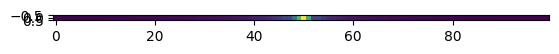

In [3]:
w = 100

intrinsics = b3d.Intrinsics(
    height=1,
    width=w,
    fx=10.0, fy=1.0,
    cx=w/2, cy=0.0,
    near=0.01, far=20.0
)
b3d.setup_renderer(intrinsics)
b3d.RENDERER.add_mesh(trimesh.util.concatenate([mesh, table]), center_mesh=False)

def render(p):
    return b3d.RENDERER.render(b3d.t3d.inverse_pose(p)[None,...], jnp.array([0]))


t = 20
p = _ps3d[t]
x,r = unpack_pose(p)

img = render(p)
img_ = img[:,:,2].at[img[:,:,3]==0].set(jnp.nan)

# -----------------
plt.imshow(img_)

In [5]:
@genjax.gen
def b3d_model():
    
    x  = genjax.tfp_uniform(jnp.array([-20.,-20.]), jnp.array([20.,20.])) @ "x"
    hd = genjax.tfp_uniform(-jnp.pi, jnp.pi) @ "hd"

    p = pack_pose(jnp.array([x[0], x[1], 0.0]), from_euler(hd,0.0,0.0))

    rendered = render(p)
   
    variance      = genjax.distributions.tfp_uniform(0.0001, 0.1) @ "sig"
    outlier_prob  = genjax.distributions.tfp_uniform(0.0001, 0.1) @ "outlier"

    image         = b3d.genjax.image_likelihood(rendered, variance, outlier_prob, 20.0) @ "imgage"

    return p, rendered, image

In [136]:
key, = jax.random.split(key, 1)
ch  =  genjax.choice_map({
        "x":  _xs[0],
        "hd": _hds[0],
        "variance": 0.1,
        "outlier_prob": 0.1,
})

key, (w,tr) = model.importance(key, ch, ())
w

Array(-4.608465, dtype=float32)

In [137]:
def choices(**kwargs): return genjax.choice_map(kwargs)

In [138]:
def _eval_pose(trace, key, p):
    ch    = choices(x=p[:2], hd=p[2])
    diffs = tuple(map(lambda v: Diff(v, UnknownChange), trace.args))

    return trace.update(key, ch, diffs)[1][2].get_score()

jeval_poses = jax.jit(jax.vmap(_eval_pose, in_axes=(None, None, 0)))

In [141]:
key, = jax.random.split(key, 1)
ps = np.random.randn(30_000, 3)
%timeit -n 1 -r 1 jeval_poses(tr, key, ps).block_until_ready()

41.4 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


In [142]:
def vector_grid(v0, shape, r, flat=False):
    r = jnp.array(r)
    vs = np.stack(jnp.indices(shape), axis=-1).reshape(-1,len(shape))
    vs = r[None]*vs
    center = (vs[0] + vs[-1])/2
    vs = vs - center + v0
    if flat: 
        return vs
    else: 
        return vs.reshape(shape)


In [143]:
v0 = jnp.array([*_xs[0], _hds[0]])
shape = (15,15,15)
res = (0.1,0.1,0.1)
vs = vector_grid(v0, shape, res, flat=True)
vs.shape

(3375, 3)

In [145]:
key, = jax.random.split(key, 1)
%timeit -n 1 -r 1 jeval_poses(tr, key, vs)

5.88 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


In [146]:
_as = create_angles(jnp.pi/2, 100)
cast(_ps[0], _as, _segs)

(Array([1.1653671, 1.1997826, 1.236613 , 1.2761077, 1.3185518, 1.3642716,
        1.413644 , 1.4671081, 1.5251733, 1.5884415, 1.6576202, 1.7335552,
        1.817262 , 1.9099666, 2.0131736, 2.1287363, 2.2589796, 2.3720582,
        2.3632843, 2.3551664, 2.3476925, 2.3408535, 2.33464  , 2.3290443,
        2.3240592, 2.3196778, 2.3158948, 2.312706 , 2.310106 , 2.3080928,
        2.306663 , 2.3058152, 2.3055482, 2.3058615, 2.3067558, 2.3082323,
        2.3102922, 2.312939 , 2.3161755, 2.3200057, 2.324435 , 2.3294685,
        2.3351138, 2.3413765, 2.348266 , 2.3557909, 2.363961 , 2.372788 ,
        2.3822827, 2.3924584, 2.403329 , 2.4149094, 2.427216 , 2.4402666,
        2.4540792, 2.468674 , 2.4840722, 2.5002975, 2.517374 , 2.535328 ,
        2.5541875, 2.5739827, 2.5947452, 2.6165094, 2.6393123, 2.663192 ,
        2.6881907, 2.7143533, 2.7417269, 2.770363 , 2.8003156, 2.831644 ,
        2.8644102, 2.8986816, 2.9345315, 2.9720364, 3.0112805, 3.0523531,
        3.0953524, 3.1403818, 3.187555

In [147]:
@genjax.gen
def model():
    

    x  = genjax.tfp_uniform(jnp.array([-20.,-20.]), jnp.array([20.,20.])) @ "x"
    hd = genjax.tfp_uniform(-jnp.pi, jnp.pi) @ "hd"

    p = jnp.array([x[0], x[1], hd])

    z,_ = jcast(p, _as, _segs)
    rendered = jnp.stack([
        _as, 
        jnp.ones(len(_as)), 
        z, jnp.ones(len(_as))
    ], axis=1)[None]
    
    variance      = genjax.distributions.tfp_uniform(0.0001, 0.1) @ "variance"
    outlier_prob  = genjax.distributions.tfp_uniform(0.0001, 0.1) @ "outlier_prob"

    image         = b3d.genjax.image_likelihood(rendered, variance, outlier_prob, 20.0) @ "imgage"
    return p, rendered, image


enumerator, enumerator_score, enumerator_parallel, enumerator_score_parallel = b3d.genjax.make_enumerator(["x","hd"])

In [148]:
key, = jax.random.split(key, 1)
ch  =  genjax.choice_map({
        "x":  _xs[0],
        "hd": _hds[0],
        "variance": 0.1,
        "outlier_prob": 0.1,
})

key, (w,tr) = model.importance(key, ch, ())
w

Array(-4.608465, dtype=float32)

In [149]:
def _eval_pose(trace, key, p):
    ch    = choices(x=p[:2], hd=p[2])
    diffs = tuple(map(lambda v: Diff(v, UnknownChange), trace.args))

    return trace.update(key, ch, diffs)[1][2].get_score()

jeval_poses = jax.jit(jax.vmap(_eval_pose, in_axes=(None, None, 0)))

In [150]:
_segs.shape

(426, 4)

In [152]:
v0 = jnp.array([*_xs[0], _hds[0]])
shape = (25,15,15)
res = (0.1,0.1,0.1)
vs = vector_grid(v0, shape, res, flat=True)

key, = jax.random.split(key, 1)
%timeit -n 1 -r 1 jeval_poses(tr, key, vs)

307 µs ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
